<a href="https://colab.research.google.com/github/Samdatascienti/Samdatascienti/blob/main/Thesi_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting things
import os
from PIL import Image
import pandas as pd
import os, cv2, random, pickle
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, MaxPool2D, SeparableConv2D, BatchNormalization
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from matplotlib.colors import LogNorm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_folder= '/content/gdrive/MyDrive/Pneumonia_normal_image_paul/chest_xray/train'
val_folder = '/content/gdrive/MyDrive/Pneumonia_normal_image_paul/chest_xray/val'
test_folder = '/content/gdrive/MyDrive/Pneumonia_normal_image_paul/chest_xray/test'

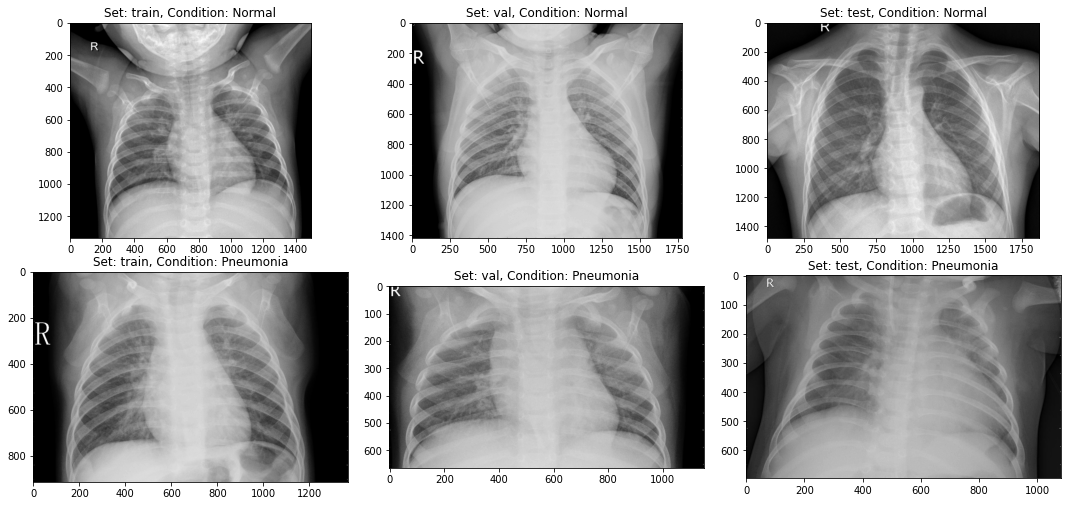

In [ ]:
input_path = '/content/gdrive/MyDrive/Pneumonia_normal_image_paul/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [ ]:
# size = 224
# training_data = []
# #create import function 
# def image_import (img_path, class_type, appended_list):
#     for i in os.listdir(img_path):
#         read_path = os.path.join(img_path, i)
#         try:
#             img = cv2.imread(read_path)
#             img = cv2.resize(img, (size, size))
#             appended_list.append([img, class_type])
#         except Exception as e:
#             print(f'Image error: {i}')
#             pass
# #import normal lung images
# img_path = '/content/gdrive/MyDrive/Pneumonia_normal_image_paul/chest_xray/train/NORMAL'
# image_import(img_path, 0, training_data)
# #import pneumonia images
# img_path = '/content/gdrive/MyDrive/Pneumonia_normal_image_paul/chest_xray/train/PNEUMONIA'
# image_import(img_path,1, training_data)

In [ ]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1355, pneumonia images: 3885
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 239, pneumonia images: 390


function in which I did some data augmentation, fed the training and test set images to the network. Also I created labels for the images.

In [ ]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels
    

After that I defined some constants for later usage.

In [ ]:
img_dims = 150
epochs = 20
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5240 images belonging to 2 classes.
Found 629 images belonging to 2 classes.


The next step was to build the model. This can be described in the following 5 steps.

I used five convolutional blocks comprised of convolutional layer, max-pooling and batch-normalization. On top of it I used a flatten layer and followed it by four fully connected layers. Also in between I have used dropouts to reduce over-fitting. Activation function was Relu throughout except for the last layer where it was Sigmoid as this is a binary classification problem. I have used Adam as the optimizer and cross-entropy as the loss. Before training the model is useful to define one or more callbacks. Pretty handy one, are: ModelCheckpoint and EarlyStopping.

ModelCheckpoint: when training requires a lot of time to achieve a good result, often many iterations are required. In this case, it is better to save a copy of the best performing model only when an epoch that improves the metrics ends. EarlyStopping: sometimes, during training we can notice that the generalization gap (i.e. the difference between training and validation error) starts to increase, instead of decreasing. This is a symptom of overfitting that can be solved in many ways (reducing model capacity, increasing training data, data augumentation, regularization, dropout, etc). Often a practical and efficient solution is to stop training when the generalization gap is getting worse.

In [ ]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)
# # Six conv block
# x = SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2))(x)
# x = Dropout(rate=0.2)(x)
# # Seventh conv block
# x = SeparableConv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = SeparableConv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2))(x)
# x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
# x = Dense(units=1024, activation='relu')(x)
# x = Dropout(rate=0.7)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)
# x = Dense(units=32, activation='relu')(x)
# x = Dropout(rate=0.3)(x)
# x = Dense(units=16, activation='relu')(x)
# x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128   

In [9]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
163/163 [==============================] - 3868s 24s/step - loss: 0.4880 - accuracy: 0.7636 - val_loss: 0.7462 - val_accuracy: 0.6217
Epoch 2/20
163/163 [==============================] - 105s 644ms/step - loss: 0.2856 - accuracy: 0.8878 - val_loss: 0.6626 - val_accuracy: 0.6217
Epoch 3/20
163/163 [==============================] - 103s 634ms/step - loss: 0.2679 - accuracy: 0.8881 - val_loss: 0.6572 - val_accuracy: 0.7714

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/20
163/163 [==============================] - 105s 641ms/step - loss: 0.2543 - accuracy: 0.8996 - val_loss: 0.4533 - val_accuracy: 0.8224
Epoch 5/20
163/163 [==============================] - 104s 638ms/step - loss: 0.2308 - accuracy: 0.9111 - val_loss: 1.0215 - val_accuracy: 0.7270
Epoch 6/20
163/163 [==============================] - 105s 643ms/step - loss: 0.1941 - accuracy: 0.9246 - val_loss: 1.9095 - val_accuracy: 0.3816
Epoch 7/20
163/163 [========================

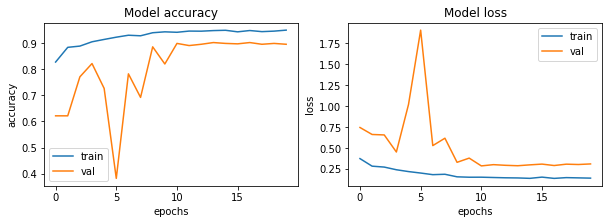

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

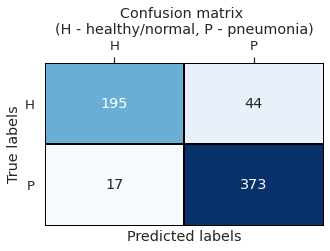


TEST METRICS ----------------------
Accuracy: 90.30206677265501%
Precision: 89.44844124700239%
Recall: 95.64102564102565%
F1-score: 92.44114002478317

TRAIN METRIC ----------------------
Train acc: 95.07


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

preds = model.predict(test_data)

# acc = accuracy_score(test_labels, np.round(preds))*100
# cm = confusion_matrix(test_labels, np.round(preds))
acc = accuracy_score(test_labels, preds >0.55)*100
cm = confusion_matrix(test_labels, preds >0.55)
tn, fp, fn, tp = cm.ravel()

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, annot=True, xticklabels=['H', 'P'], 
                 yticklabels=['H', 'P'], cbar=False, cmap='Blues',
                 linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix \n(H - healthy/normal, P - pneumonia)')
plt.show()

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

# Saliency Maps

In [20]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Pneumonia
[[0.9998716]]


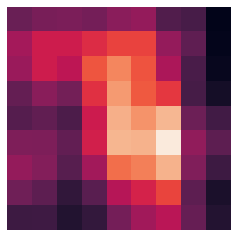

In [25]:
# img_path='../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person102_bacteria_487.jpeg'
# img_path='../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person109_bacteria_528.jpeg'
# img_path='/content/gdrive/MyDrive/Pneumonia_normal_image_paul/chest_xray/test/PNEUMONIA/person109_bacteria_522.jpeg'
img_path='/content/drive/MyDrive/Pneumonia_normal_image_paul/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg'
# img_path='../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person10_virus_35.jpeg'
# img_path='../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person11_virus_38.jpeg'
# img_path='../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person14_virus_44.jpeg'

# normal
# img_path='../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg'
# img_path='../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0022-0001.jpeg'
# img_path='../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0025-0001.jpeg'
# img_path='../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0081-0001.jpeg'
# img_path='../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0086-0001.jpeg'
# img_path='../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0019-0001.jpeg'
# img_path='../input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0059-0001.jpeg'
# img_path='../input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0059-0001.jpeg'
# img_path='../input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0312-0001.jpeg'

# last_conv_layer_name='conv5_block32_concat'
last_conv_layer_name='separable_conv2d_7'

# Prepare image
img_size=(150,150)
img_array = get_img_array(img_path, size=img_size)
img_array=img_array/255
# Make model
# model = model(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# # Print what the top predicted class is
preds = model.predict(img_array)
if preds>=0.5:
    print('Pneumonia')
else:
    print('Normal')
print(preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.axis('off')
plt.show()

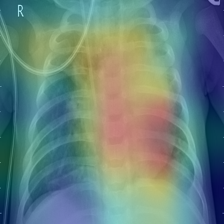

In [26]:
import matplotlib.cm as cm
def gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img


sup_img=gradcam(img_path, heatmap)
new_image = sup_img.resize((224, 224))
new_image